<a href="https://colab.research.google.com/github/dwaipayan05/CovCNN-WebApp/blob/main/COVID_Chest_X_Ray_(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Necessary Libraries**

In [26]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.models import Sequential
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt

In [27]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2
/device:GPU:0
Num GPUs Available:  1


In [28]:
%cd /content/gdrive/"My Drive"/"COVID CT scan Analysis"

/content/gdrive/My Drive/COVID CT scan Analysis


**Fetch Dataset**

In [29]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/COVID CT scan Analysis"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/MyDrive/COVID CT scan Analysis. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


**Split Into Train Data & Test Data**

In [30]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/COVID CT scan Analysis/Dataset'
train_dir = os.path.join(data_dir)

In [31]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


**Define Model Architecture**

In [32]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(64))
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(1))
resnet_model.add(Activation('sigmoid'))
resnet_model.summary()

resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
resnet_model._name = "ResNet50_Architecture"
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
 activation_3 (Activation)   (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Train the Model**

In [9]:
history = resnet_model.fit(train_ds, epochs=10,
                              validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 194s 3s/step - loss: 0.5482 - accuracy: 0.7194 - val_loss: 0.4648 - val_accuracy: 0.8004
Epoch 2/10
63/63 [==============================] - 12s 169ms/step - loss: 0.4952 - accuracy: 0.7471 - val_loss: 0.4002 - val_accuracy: 0.8427
Epoch 3/10
63/63 [==============================] - 12s 168ms/step - loss: 0.4248 - accuracy: 0.7955 - val_loss: 0.4518 - val_accuracy: 0.7581
Epoch 4/10
63/63 [==============================] - 11s 168ms/step - loss: 0.4207 - accuracy: 0.7990 - val_loss: 0.3137 - val_accuracy: 0.8669
Epoch 5/10
63/63 [==============================] - 11s 167ms/step - loss: 0.3779 - accuracy: 0.8131 - val_loss: 0.3304 - val_accuracy: 0.8528
Epoch 6/10
63/63 [==============================] - 11s 166ms/step - loss: 0.3332 - accuracy: 0.8408 - val_loss: 0.2998 - val_accuracy: 0.9073
Epoch 7/10
63/63 [==============================] - 11s 168ms/step - loss: 0.3183 - accuracy: 0.8539 - val_loss: 0.2392 - val_accuracy: 0.9194
E

**Plot the Results**

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

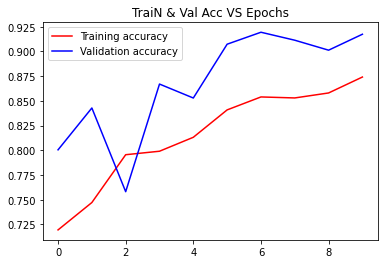

<Figure size 432x288 with 0 Axes>

In [11]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

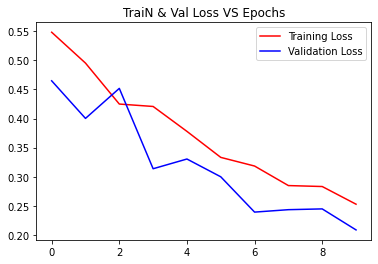

<Figure size 432x288 with 0 Axes>

In [12]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [13]:
      
score = resnet_model.evaluate(val_ds,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 3s 103ms/step - loss: 0.2086 - accuracy: 0.9173
Test Loss: 0.20856671035289764
Test accuracy: 91.73387289047241
